In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fitsio
from desiutil.log import get_logger#, DesiLogContext, WARNING
from astropy.table import Table, Column, hstack, vstack, join
from desitarget.io import read_targets_in_tiles
import glob
import sklearn.metrics
log = get_logger()

In [2]:
desi_root = desi_root = os.getenv('DESI_ROOT')
projectdir = os.path.join(desi_root, 'users', 'ioannis', 'fastspecfit', 'redrock-templates')

In [3]:
projectdir

'/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates'

In [4]:
def read_vi(vi_spectype=None, quality=2.5):
    # see https://data.desi.lbl.gov/doc/releases/edr/vac/vi/
    from glob import glob
    #vifiles = glob('/global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/*.csv')
    allvi = []
    for targ in ['BGS', 'LRG', 'ELG', 'QSO']:
        vifile = f'/global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/EDR_VI_{targ}_v1.csv'
        vi = Table.read(vifile)
        vi['SUFFIX'] = targ # os.path.basename(vifile).replace('EDR_VI_', '').replace('_v1.csv', '')
        allvi.append(vi)
    allvi = vstack(allvi)
    I = np.where(allvi['VI_QUALITY'] >= quality)[0]
    log.info(f'Trimming to {len(I):,d}/{len(allvi):,d} VI redshifts.')
    allvi = allvi[I]

    _, uindx = np.unique(allvi['TARGETID'], return_index=True)
    log.info(f'Trimming to {len(uindx):,d}/{len(allvi):,d} unique targets.')
    allvi = allvi[uindx]

    if vi_spectype:
        I = allvi['VI_SPECTYPE'] == vi_spectype
        log.info(f'Trimming to {np.sum(I):,d}/{len(allvi):,d} objects with VI_SPECTYPE={vi_spectype}.')
        allvi = allvi[I]
    
    return allvi

In [5]:
all_vi = read_vi()
assert np.unique(all_vi["TARGETID"]).size == len(all_vi)

tiles_edr = Table.read('/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/tiles-fuji.fits')

tiles_sv = tiles_edr[((tiles_edr['SURVEY']=='sv3')|(tiles_edr['SURVEY']=='sv1'))&(tiles_edr['PROGRAM']!='backup')]
tiles_sv['RA'], tiles_sv['DEC'] = tiles_sv['TILERA'], tiles_sv['TILEDEC']

tileid_vi = list(set(all_vi["TILEID"]))
tilera_vi = []
tiledec_vi = []
for tileid in tileid_vi:
    ii = tiles_edr['TILEID']==tileid
    tilera_vi.append(float(tiles_edr['TILERA'][ii]))
    tiledec_vi.append(float(tiles_edr['TILEDEC'][ii]))
    print(np.count_nonzero(ii))
tiles_vi = Table()
tiles_vi["TILEID"], tiles_vi["RA"], tiles_vi["DEC"] = tileid_vi, tilera_vi, tiledec_vi

INFO:3386545520.py:13:read_vi: Trimming to 17,275/20,373 VI redshifts.
INFO:3386545520.py:17:read_vi: Trimming to 17,083/17,275 unique targets.
1
1
1
1
1
1
1
1


In [6]:
tiles_vi

TILEID,RA,DEC
int64,float64,float64
80608,106.74,56.2
80609,150.12,2.206
80610,150.12,2.306
80613,106.74,56.1
80670,38.0,-2.8
80605,36.448,-4.601
80606,36.448,-4.501
80607,106.74,56.1


In [7]:
tiles_sv

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,RA,DEC
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32,float64,float64
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217,150.12,2.206
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219,106.74,56.1
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219,36.448,-4.501
80620,sv1,dark,lrgqso,sv1lrgqso,9,8100.5,144.0,65.0,0.0,7128.7,0.0,4000.0,obsstart,6643.9,7128.7,6299.8,6316.1,dark,0.9,20201221,144.0,65.0
80622,sv1,dark,lrgqso,sv1lrgqso,6,5400.3,155.0,32.325,0.0,4916.9,0.0,4000.0,obsstart,4772.1,4916.9,4739.8,6935.4,dark,0.9,20201221,155.0,32.325
80623,sv1,dark,elg,sv1elg,8,7200.4,155.0,32.425,0.0,4969.7,0.0,4000.0,obsstart,4903.1,4969.7,4916.9,7266.2,dark,0.9,20201221,155.0,32.425
80611,sv1,bright,bgsmws,sv1bgsmws,12,3600.9,35.22,30.3,0.0,669.2,0.0,600.0,obsstart,641.1,723.7,669.2,407.7,bright,0.9,20201222,35.22,30.3
80617,sv1,bright,bgsmws,sv1bgsmws,16,4801.0,5.0,28.0,0.0,1309.5,0.0,600.0,obsstart,1251.7,1369.7,1309.5,884.1,bright,0.9,20201223,5.0,28.0
80608,sv1,dark,elg,cmxelg,23,20701.4,106.74,56.2,0.0,15166.0,0.0,4000.0,obsstart,14236.7,15166.0,13797.6,14267.9,dark,0.9,20201223,106.74,56.2


In [8]:
hpdirname = "/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/dark"
main_dark = Table(read_targets_in_tiles(hpdirname, tiles=tiles_sv, quick=True))
assert np.unique(main_dark["TARGETID"]).size == len(main_dark)


In [9]:
hpdirname = "/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright"
main_bright = Table(read_targets_in_tiles(hpdirname, tiles=tiles_sv, quick=True))
assert np.unique(main_bright["TARGETID"]).size == len(main_bright)

In [12]:
in_dark = np.in1d(all_vi['TARGETID'], main_dark['TARGETID'])
in_bright = np.in1d(all_vi['TARGETID'], main_bright['TARGETID'])
print(np.count_nonzero(in_dark|in_bright))

8039


In [23]:
all_vi_in_main = all_vi[in_dark|in_bright]

In [25]:
all_vi_in_main.sort('TARGETID')

In [27]:
all_vi_in_main

TARGETID,TILEID,FIBER,TARGET_RA,TARGET_DEC,VI_Z,VI_QUALITY,VI_SPECTYPE,SUFFIX
int64,int64,int64,float64,float64,float64,float64,str6,str3
39627634551824898,80605,398,36.18946453136912,-6.149115843122294,0.355,4.0,GALAXY,LRG
39627634556011094,80605,363,36.21608882431832,-6.128186295203432,1.394,3.0,QSO,QSO
39627634556012263,80605,397,36.24615239723666,-6.138445768391183,1.5468,4.0,QSO,QSO
39627634556014615,80605,478,36.304035269010576,-6.177153479731488,1.3637,3.0,QSO,QSO
39627634556015764,80605,191,36.33448600336392,-6.150640067188368,0.7977,4.0,GALAXY,LRG
39627634560205781,80605,466,36.48114966071196,-6.13055187981307,1.3499,4.0,QSO,QSO
39627634560209346,80605,484,36.59674297649576,-6.154760155818011,0.7606,4.0,GALAXY,QSO
39627634564402484,80605,311,36.81021305541879,-6.128079808810531,0.4328,4.0,GALAXY,LRG
39627640549678023,80605,693,35.58220218605675,-5.893069788147125,0.5093,4.0,GALAXY,LRG


In [95]:
path_A = '/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-iron/vitiles/'


other_templates = ['redux-templates-NMF-0.1-zscan01',
'redux-templates-NMF-0.2-zscan01',
'redux-templates-NMF-0.3-zscan01',
'redux-templates-NMF-0.4b-zscan01',
'redux-templates-NMF-0.4-zscan01',
'redux-templates-NMF-0.5b-zscan01',
'redux-templates-NMF-0.5-zscan01',
'redux-templates-PCA-0.1-zscan01',
'redux-templates-PCA-0.2-zscan01']

paths  = []

for temp in other_templates:
    tmp_path = '/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/{}/vitiles/'.format(temp)
    print(tmp_path)
    paths.append(tmp_path)



/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.1-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.2-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.3-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.4b-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.4-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5b-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-PCA-0.1-zscan01/vitiles/
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redu

In [93]:
def gather_redrock_outputs(redrock_path):
    zcatfiles = glob.glob(os.path.join(redrock_path,'zcat*.fits'))
    zcat = vstack([Table(fitsio.read(zcatfile)) for zcatfile in zcatfiles])
    return zcat

In [88]:
def precision_recall(redrock_path, all_vi_data_in_main):
    labels = ['GALAXY', 'QSO', 'STAR']
    zcat = gather_redrock_outputs(redrock_path)
    in_truth = np.isin(zcat['TARGETID'], all_vi_data_in_main['TARGETID'])
    zcat = zcat[in_truth]
    zcat.sort('TARGETID')
    assert np.unique(zcat['TARGETID']).size == len(zcat)
    recall = sklearn.metrics.recall_score(all_vi_in_main['VI_SPECTYPE'], zcat['SPECTYPE'], average=None, labels=labels)
    precision = sklearn.metrics.precision_score(all_vi_in_main['VI_SPECTYPE'], zcat['SPECTYPE'], average=None, labels=labels)
    f1 = sklearn.metrics.f1_score(all_vi_in_main['VI_SPECTYPE'], zcat['SPECTYPE'], average=None, labels=labels)

    return precision, recall, f1

In [98]:
A = precision_recall(path_A, all_vi_in_main)
print(A)

(array([0.97316448, 0.98503937, 1.        ]), array([0.99706518, 0.9032491 , 0.75555556]), array([0.98496986, 0.94237288, 0.86075949]))


/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.1-zscan01/vitiles/
[-0.00071753  0.00239226  0.00883832]
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.2-zscan01/vitiles/
[0.00266135 0.00872665 0.0661277 ]
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.3-zscan01/vitiles/
[-0.18427579 -0.35723239 -0.20885594]
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.4b-zscan01/vitiles/
[0.00563295 0.01334203 0.11577354]
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.4-zscan01/vitiles/
[0.00620916 0.01370914 0.10856492]
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NMF-0.5b-zscan01/vitiles/
[0.00632012 0.01794819 0.11261245]
/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/stacks/redux-templates-NM

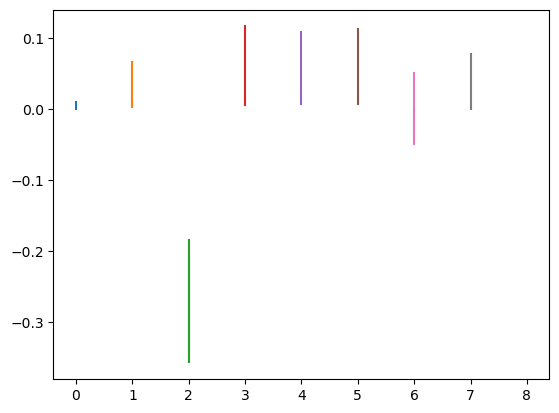

In [105]:
for i, path in enumerate(paths):
    print(path)
    B = precision_recall(path, all_vi_in_main)
    delta = B[2]-A[2]
    print(delta)
    plt.plot(np.ones(3)*i, delta)

In [100]:
A[0]

array([0.96893291, 0.98554217, 1.        ])